# Initialisation du notebook

L'objectif du module est de développer un système de suggestion de tag pour le site Stack Overflow. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.

Ce notebook se consacre au préprocessing des données textuelles.

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold=10

<IPython.core.display.Javascript object>

In [2]:
# -*- coding: utf-8 -*-
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os, pickle, warnings
from sklearn.utils import resample
import re, spacy, nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from string import punctuation

# no recognition of dependency labels and named entities 
nlp = spacy.load('en', disable=['parser', 'ner'])   
#print(_nlp.pipe_names)

# Create a Tokenizer with the default settings for English
# including punctuation rules and exceptions
spacy_tokenizer = nlp.Defaults.create_tokenizer(nlp)
# Spacy va permettre de gérer ce genre de cas : i'm having issues. 
# Plutôt de renvoyer "i", "m", Spacy va renvoyer "i", "'m"
# tokens = tokenizer("i'm having issues")

# Déclaration de variables 
data_path = r"C:\OCR\06 _ Catégorisez automatiquement des questions"
   
pd.options.mode.chained_assignment = None # default='warn'
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.2f}'.format
warnings.filterwarnings("ignore")

In [3]:
# CHARGEMENT
with open('alltags_counter.pkl', 'rb') as f:
    alltags_counter = pickle.load(f) 

top100tags = [tag[0]+'>' for tag in alltags_counter.most_common(100)]

posts_body = pd.read_pickle('./posts_body.pkl')
posts_top100tags = pd.read_pickle('./posts_top100tags.pkl')
posts_top100tags_3labels = pd.read_pickle("./posts_top100tags_3labels.pkl")

# Préprocessing des données textuelles

- Suppression du format html avec le package Beautiful Soup 
- Mise en minuscules du texte 
- Transformations des abréviations
- Suppression des stop words proposés par les modules NLP
- Lemmatisation
- Suppression des verbes et adjectifs qui n'apportent de valeur ajoutée pour ce que je souhaite faire
- Suppression de stop words manuels

In [4]:
few_posts = resample(posts_body, n_samples=10, random_state=0)

In [5]:
def clean_text(text):
    ''' Lowering text and removing undesirable marks
    Parameter:
    text: corpus to clean
    '''

    
    text = text.lower()
    text = re.sub(r"\'\n", " ", text) # removes line feeds
    text = re.sub(r"\'\xa0", " ", text) # removes spaces
    text = re.sub('\s+', ' ', text) # matches all whitespace characters : \t\n\r\f\v
    text = text.strip(' ') # removes leading and trailing blanks
    
    return text

In [6]:
posts_body_clean1 = posts_body.apply(lambda x: clean_text(x))

# the text of the post, without tags or markup
posts_body_clean2 = posts_body_clean1.apply(lambda x: BeautifulSoup(x).get_text())

In [7]:
# avant nettoyage
posts_body_clean1.loc[few_posts.index].sort_index()

3160     <p>what are some real world places that call for delegates? i'm curious what situations or patterns are present where this method is the best solution. no code required.</p>                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [8]:
# après nettoyage
posts_body_clean2.loc[few_posts.index].sort_index()

3160     what are some real world places that call for delegates? i'm curious what situations or patterns are present where this method is the best solution. no code required.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [9]:
def clean_punctuation(text, ignore_words): 
    ''' Remove punctuation
    Parameters:
    text: corpus to remove punctuation from it
    ignore_words: list of words to include without processing them
    '''
    
    
    words = spacy_tokenizer(text)
    punctuation_filtered = []
    regex = re.compile('[%s]' % re.escape(punctuation))
    
    for w in words:
        # certains mots peuvent être des tags qui contiennent des signes de ponctuation, il faut les conserver tels quels
        # en utilisant une liste de top tags la plus exhaustive possible
        if '<'+str(w)+'>' in ignore_words: 
            punctuation_filtered.append(str(w))
        else:
            w = re.sub('[0-9]', ' ', str(w)) # word contains no digits
            punctuation_filtered.append(regex.sub(' ', str(w)))
        
    result = ' '.join(punctuation_filtered)
    result = re.sub(' +', ' ', result) # remove duplicates whitespaces
    
    return result 

In [10]:
posts_body_clean3 = posts_body_clean2.apply(lambda x: clean_punctuation(x, top100tags))

In [11]:
# après nettoyage
posts_body_clean3.loc[few_posts.index].sort_index()

3160     what are some real world places that call for delegates i m curious what situations or patterns are present where this method is the best solution no code required                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [12]:
print(posts_body_clean3.loc[posts_body_clean3.str.contains(re.escape('c++'))].head(1))

10    i m having issues getting the c sockets api to work properly in c++ on z os although i am including sys socket h i still get compile time errors telling me that af inet is not defined am i missing something obvious or is this related to the fact that being on z os makes my problems much more complicated update upon further investigation i discovered that there is an ifdef that i m hitting apparently z os is n t happy unless i define which type of sockets i m using with define oe sockets now i personally have no idea what this oe sockets is actually for so if any z os sockets programmers are out there all of you perhaps you could give me a rundown of how this all works test app include sys socket h int main return af inet compile link output cxx wc xplink wl xplink o inet test inet c inet c line ccn s the name lookup for af inet did not find a declaration ccn i compilation failed for file inet c object file not created a check of sys sockets h does include the definition i need an

In [13]:
def stopWordsRemove(text, stop_words):
    ''' Removing all the english stop words from a corpus
    Parameter:
    text: corpus to remove stop words from it
    stop_words: list of stop words to exclude
    '''

    
    words = spacy_tokenizer(text)
    filtered = [str(w) for w in words if not str(w) in stop_words]
    text = ' '.join(map(str, filtered))
    result = re.sub(' +', ' ', text) # remove duplicates whitespaces
    
    return result

In [14]:
def lemmatization(text_in, allowed_postags, ignore_words):
    ''' It keeps the lemma of the words (lemma is the uninflected form of a word),
    and deletes the undesired POS tags
    
    Parameters:
    
    text_in (list): text to lemmatize
    allowed_postags (list): list of allowed postags, like NOUN, ADJ, VERB, ADV
    ignore_words: list of words to include without processing them
    '''

    
    doc = nlp(text_in) 
    text_out = []
    
    for token in doc:
        
        if str(token) in ignore_words:
            text_out.append(str(token))
            
        elif token.pos_ in allowed_postags:            
            text_out.append(token.lemma_)
                
    text_out = ' '.join(text_out)
    result = re.sub(' +', ' ', text_out) # remove duplicates whitespaces

    return result

Il y a pas mal de mots (ex: like, use, get, new) qui n'apportent aucune information pertinente sur le contenu de la question. 

Je me focalise donc sur les noms essentiellement. 

In [15]:
auto_stopwords = set(set(nlp.Defaults.stop_words) | set(stopwords.words("english")))
posts_body_clean4 = posts_body_clean3.apply(lambda x: stopWordsRemove(x, auto_stopwords)) 
posts_body_clean5 = posts_body_clean4.apply(lambda x: lemmatization(x, ['NOUN'], top100tags))

In [16]:
# après nettoyage
posts_body_clean5.loc[few_posts.index].sort_index()

3160     world place situation pattern method solution code                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
35063    concept compilation runtime platform compiler language compiler c output compiler compiler generate output source build operation output compiler process question detail process script doc thing language design compilation advantage concept people concept edit thank information research question compiler run source time type output script example source concept nature                    

In [17]:
print(posts_body_clean5.loc[posts_body_clean5.str.contains(re.escape('c++'))].head(1))

61635    year c c++ source need diving asp.net video source project code thank
Name: Body, dtype: object


In [18]:
#doc = nlp("successfully")
#for token in doc:
#    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_, token.shape_, token.is_alpha, token.is_stop)

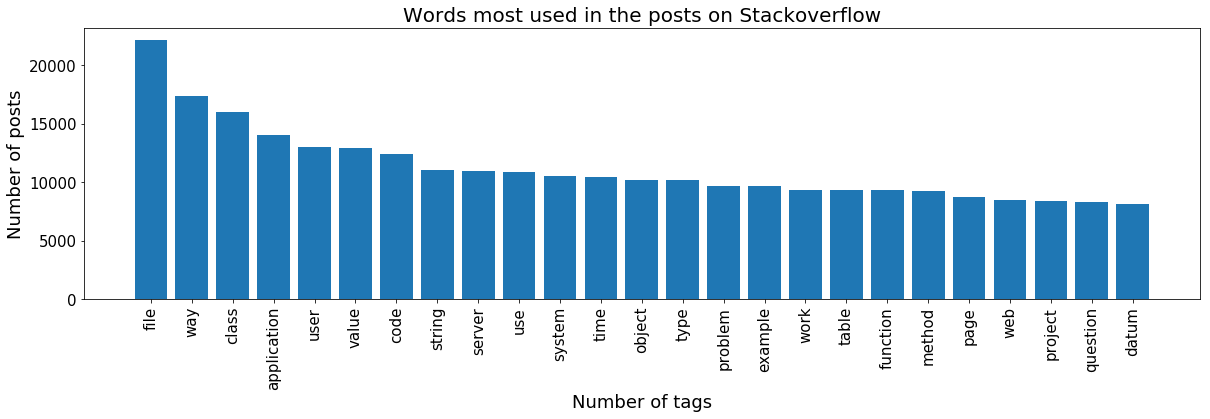

In [19]:
import matplotlib.pyplot as plt
# Graph showing the words most used in the post on Stackoverflow

txt = posts_body_clean5.str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(txt)
word_dist = nltk.FreqDist(words)
result = pd.DataFrame(word_dist.most_common(25),columns=['Word','Frequency'])

plt.figure(figsize=(20, 5))
plt.xlabel('Number of tags', fontsize=18)
plt.ylabel('Number of posts', fontsize=18)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.bar(result.Word, result.Frequency)
plt.title("Words most used in the posts on Stackoverflow",fontsize=20)
plt.style.use('fivethirtyeight')
plt.show()

In [20]:
result = pd.DataFrame(word_dist.most_common(200),columns=['Word','Frequency'])
display(result)

,Word,Frequency
0,file,22118
1,way,17360
2,class,16022
3,application,14039
4,user,13039
5,value,12962
6,code,12425
7,string,11062
8,server,10943
9,use,10838


Dans le lot, il y a des mots "fourre-tout" que j'intègre aux stopwords et je réapplique la fonction de suppression des stopwords. 

In [21]:
manual_stopwords = ['file', 'way', 'application', 'user', 'use', 'method',
                    'example', 'problem', 'work', 'test', 'question', 'project', 'thank',
                    'return', 'solution', 'thing', 'change', 'program', 'idea', 'end',
                    'message', 'result', 'answer', 'issue', 'language', 'information',
                    'document', 'e', 'default', 'help', 'people', 'run', 'testing',
                    'difference', 'stuff', 'need', 'response', 'check', 'product', 'approach', 
                    'want', 'suggestion', 'n', 'custom', 'create', 'p', 'place', 'comment',
                    'support', 'person', 'expression']

manual_stopwords = set(manual_stopwords)
posts_body_clean5 = posts_body_clean5.apply(lambda x: stopWordsRemove(x, manual_stopwords)) 

In [22]:
print(posts_body_clean5.loc[posts_body_clean5.str.contains(re.escape('c++'))].head(1))

61635    year c c++ source diving asp.net video source code
Name: Body, dtype: object


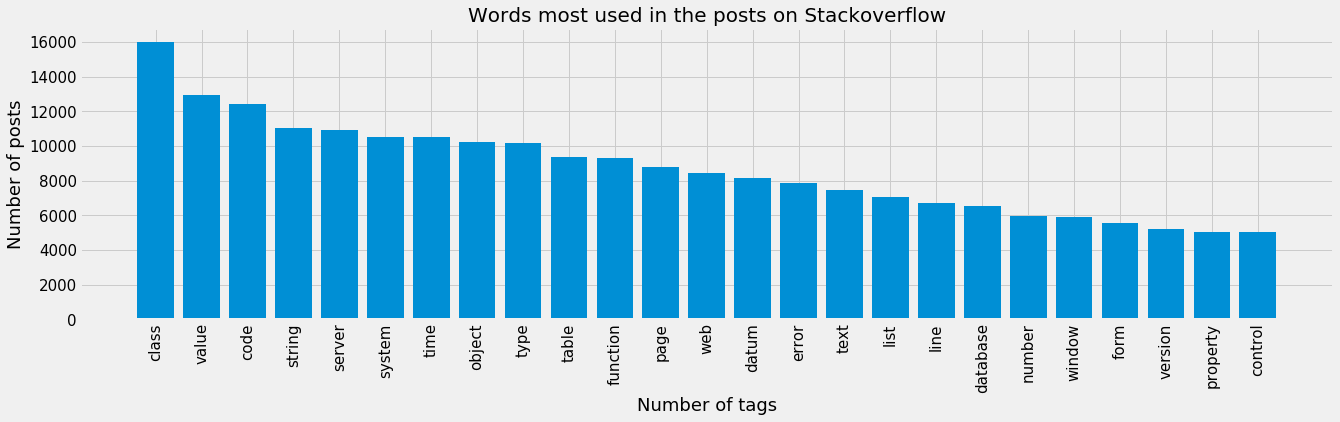

In [23]:
import matplotlib.pyplot as plt
# Graph showing the words most used in the post on Stackoverflow

txt = posts_body_clean5.str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(txt)
word_dist = nltk.FreqDist(words)
result = pd.DataFrame(word_dist.most_common(25),columns=['Word','Frequency'])

plt.figure(figsize=(20, 5))
plt.xlabel('Number of tags', fontsize=18)
plt.ylabel('Number of posts', fontsize=18)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.bar(result.Word, result.Frequency)
plt.title("Words most used in the posts on Stackoverflow",fontsize=20)
plt.style.use('fivethirtyeight')
plt.show()

In [24]:
# SAUVEGARDE
posts_body_clean5.to_pickle("./posts_body_clean5.pkl")